## Data Exploration/Analysis

Ultimate goal is to predict median sale price per square foot of a house.

Current step: EDA

Next step: PCA and Clustering. See what patterns emerge in the clusters.

Final step: predict median sale price per square foot.

Questions:

* What kind of buiding types are in a high-value neighborhood?

* What correlates with high housing prices?
    * Distance from city center? 
    * Neighborhood composition of the buildings (a lot of multi-family or mixture of uses leads to higher PPSF)?
    * Half-baths
    * 
    
* What kind of neighborhoods experience multi-parcel sales?

* How do housing prices change over time?

* Flirting with the idea of Assessment Improvement / Assessment Total ratio as a good predictor of PPS. Be warned this is only so useful because assessments are done after the property is built and use metrics derived from other data. However when averaged across the neighborhood it could show promise. Hypothesis: A neighborhood with low assessment ratio but high population density will get gentrified
    * McMansion neighborhoods will have a high-ish improvement assessment, on cheap land
    * Assessment very much depends on the time it was assessed so we will need to do a time series comparison to get valuable insight.

* How does square footage correlate with price?

* Does population density correlate with price?

* How do building heights correlate with prices?

* Does building frame/exterior wall material affect price in the neighborhood?

* How do we deal with zipcodes?

## Questions to ask Davidson Co:

* 'Fixtures' feature

* Building Grade

* Tax District

* Sold as Vacant

## Observations:

Multifamily is usually listed with a 'Land Area' of 0.

Condos/apartments, no matter how tall their building, are listed with a height of 1 :/

Really need to start dropping extraneous columns, especially 'assessment' and 'appraisal' values and redundant columns.

From what I can tell, all areas near downtown (east, north and west) are gentrifying. The South side was already middle-class.

## Zones for reference:

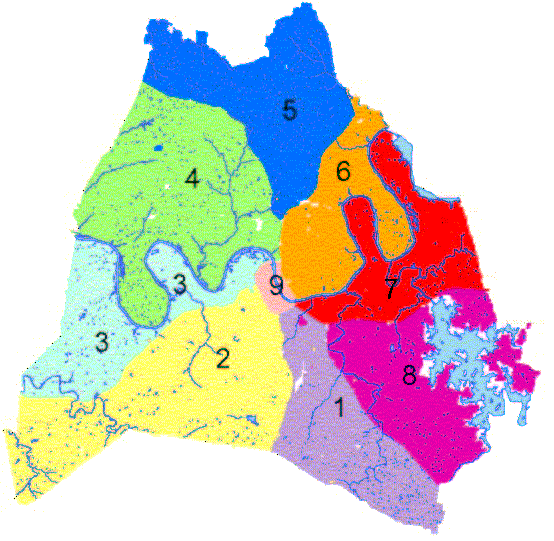

## Neighborhoods (arbitrary/unofficial):

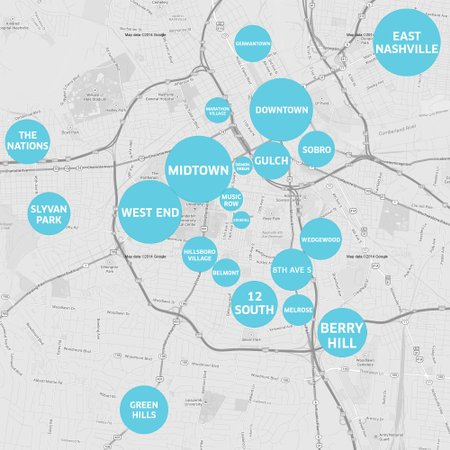

## Zipcodes for Reference

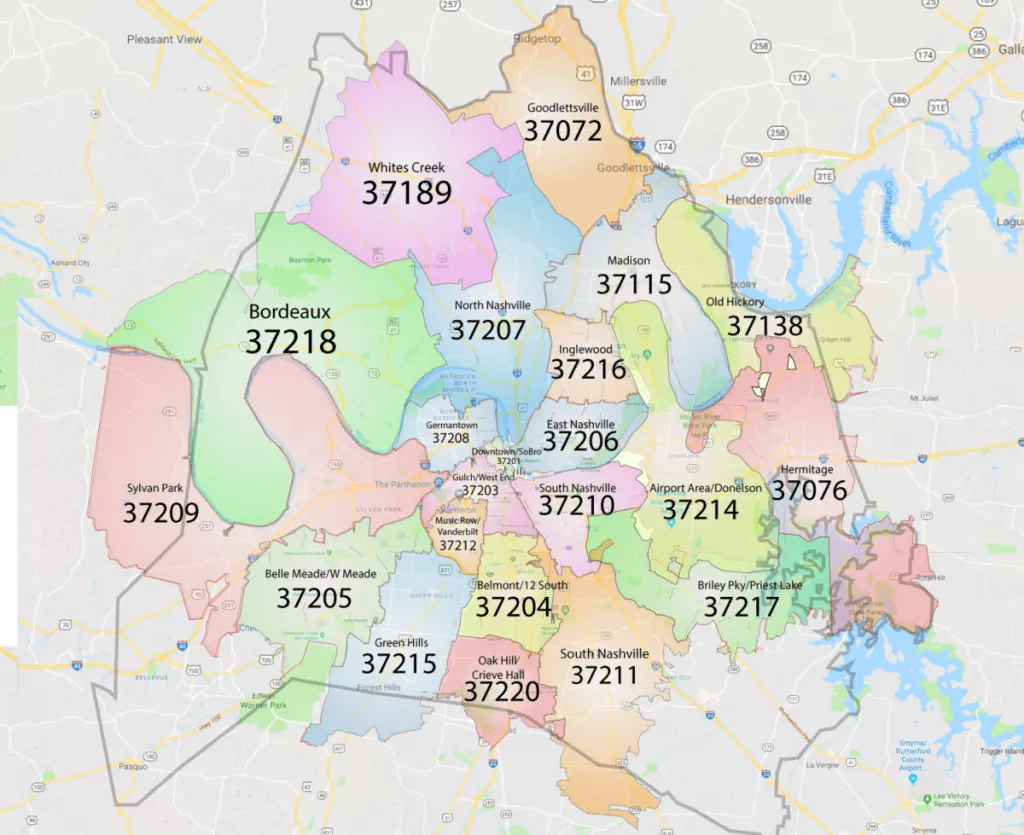

## Motivation

Nashville is one of the nation's fastest-growing metro areas, often billed as a 'superstar' city with exemplary economic development that other cities strive for. In this project we want to determine which neighborhoods are experiencing the most growth, and what they have in common. Hopefully this will tell us which neighborhood is ripe for development (or population loss). 

https://www.reuters.com/article/us-usa-economy-nashville-insight/as-u-s-superstar-cities-thrive-weaker-ones-get-left-behind-idUSKCN1UE13B

https://www.governing.com/gov-data/nashville-gentrification-maps-demographic-data.html



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
%matplotlib inline
sns.set(style='darkgrid')

In [2]:
df1=pd.read_csv('nashville_20190813150235.csv', parse_dates = ['Most Recent Sale Date', 'Sale Date'], dtype={'Zone': str, 'Neighborhood': str})

C:\Users\alehe\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df1.shape

(281887, 56)

In [44]:
df1.head()

,Unnamed: 0,Assessment Classification*,Assessment Improvement,Assessment Land,Assessment Total,Assessment Year,Baths,Beds,Building Condition,Building Grade,...,Assessment Improvement Improved,Most Recent Sale Price Improved,Improvement Value Improved,Assessment Total Improved,Land Value Improved,Assessment Land Improved,Total Appraisal Value Improved,Square Footage Improved,Building Type Custom,Land Area Acres
0,0,AG/RES,$0,"$2,655","$2,655",2019,NaN,NaN,NaN,NaN,...,2655.0,7500.0,0.0,2655.0,10621.0,2655.0,10621.0,0.0,NaN,7.60
1,1,AG/RES,$0,"$4,081","$4,081",2019,NaN,NaN,NaN,NaN,...,4081.0,12500.0,0.0,4081.0,16323.0,4081.0,16323.0,0.0,NaN,8.90
2,2,EXE,$0,$0,$0,2019,NaN,NaN,NaN,NaN,...,0.0,67000.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2.90
3,3,EXE,$0,$0,$0,2019,2.0,3.0,Poor,E,...,0.0,67000.0,34800.0,0.0,12300.0,0.0,47100.0,1224.0,SINGLE FAM,0.79
4,4,EXE,$0,$0,$0,2019,NaN,NaN,NaN,NaN,...,0.0,67000.0,0.0,0.0,27400.0,0.0,27400.0,0.0,NaN,2.11


In [65]:
df.isna().sum()

Unnamed: 0                               0
Assessment Classification*               0
Assessment Improvement                   0
Assessment Land                          0
Assessment Total                         0
Assessment Year                          0
Baths                                 2329
Beds                                  2528
Building Condition                    2496
Building Grade                        2497
Building Type                         2497
Current Owner                            0
Deed Reference                           0
Exterior Wall                         2497
Fixtures                              2540
Foundation Type                       2502
Frame Type                           13035
Half Bath                             2765
Improvement Value                        0
Land Area                                0
Land Value                               0
Location                                 0
Mailing Address                          0
Map & Parce

In [4]:
#Creating new dataframe without duplicate entires
df=df1.sort_values(by='Sale Date').drop_duplicates(subset='Map & Parcel', keep = 'last')
#Dropping parcels that were involved in multi-parcel sales
df=df[df['Multiple Parcels Involved in Sale'] == 'No']
#Want to create a new column which is the mean sale price per square foot of a parcel in that neighborhood
df['PPS']=df['Sale Price']/df['Square Footage Improved']
df['PPS']=df['PPS'].replace(np.inf, np.nan)
meanpps=df.groupby('Neighborhood')['PPS'].mean().to_frame().rename(columns={'PPS':'NeighborhoodPPS'})
df=df.merge(meanpps, how='left', left_on = 'Neighborhood',right_index=True)

In [6]:
len(meanpps)

819

In [6]:
import jsoncleaner
df['Assessment Improvement'] = jsoncleaner.dolcomma(df['Assessment Improvement'])
df['Assessment Total'] = jsoncleaner.dolcomma(df['Assessment Total'])
#Neighborhood and Zone are numbers, but categorical.
df['Neighborhood'] = df['Neighborhood'].map(lambda x: str(x) if pd.notnull(x) else None)
df['Zone'] = df['Zone'].map(lambda x: str(x) if pd.notnull(x) else None)

In [8]:
df['Sold As Vacant'].value_counts()

No     55755
Yes     1109
Name: Sold As Vacant, dtype: int64

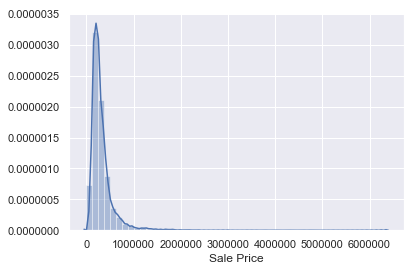

In [9]:
sns.distplot(df['Sale Price'])

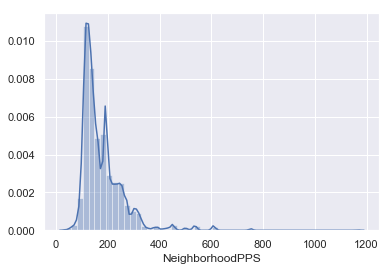

In [10]:
sns.distplot(df['NeighborhoodPPS'].dropna())

In [13]:
#Examining observations with abnormally large PPS
meanpps.nlargest(20,'NeighborhoodPPS')
#Lots of observations in neighborhood 9026, all are in Zone 2

,NeighborhoodPPS
Neighborhood,
9527,1169.199296
6264,752.879821
9026,609.146870
6011,602.827175
6442,536.781227
6375,523.752618
4267,506.597339
4098,495.971656
6444,463.819647


In [12]:
df[df['Neighborhood']=='9026'][['Location', 'Sale Price']]
#This is a neighborhood of huge houses, probably owned by country musicians. It's called "Belle Meade" in SW Nashville

,Location,Sale Price
129481,306 JACKSON BLVD,660000.0
148364,605 LYNNWOOD BLVD,892000.0
129653,332 WALNUT DR,532500.0
128811,105 BELLE MEADE BLVD,3100000.0
148399,615 WESTVIEW AVE,1475000.0
130343,4324 SIGNAL HILL DR,986000.0
148322,4312 SUNNYBROOK DR,400000.0
149399,807 LYNNWOOD BLVD,515000.0
149393,907 LYNNWOOD BLVD,505000.0
129673,404 LYNNWOOD BLVD,700000.0


In [20]:
nbhd9026 = df[df['Neighborhood']=='9026']
#Mean sale price of #1.44 million, mean PPS of $609.  
nbhd9026.describe()

,Unnamed: 0,Assessment Improvement,Assessment Total,Assessment Year,Baths,Beds,Fixtures,Half Bath,Number of Living Units,Rooms,...,Most Recent Sale Price Improved,Improvement Value Improved,Assessment Total Improved,Land Value Improved,Assessment Land Improved,Total Appraisal Value Improved,Square Footage Improved,Land Area Acres,PPS,NeighborhoodPPS
count,237.000000,237.000000,2.370000e+02,237.0,225.000000,225.000000,224.000000,224.000000,225.0,225.000000,...,2.370000e+02,2.370000e+02,2.370000e+02,2.370000e+02,237.000000,2.370000e+02,237.000000,237.000000,225.000000,2.370000e+02
mean,141755.198312,211253.691983,4.046717e+05,2019.0,3.862222,3.955556,16.803571,0.633929,1.0,9.568889,...,1.443756e+06,8.450148e+05,4.046717e+05,7.736722e+05,193418.037975,1.618687e+06,4456.443038,1.114515,609.146870,6.091469e+02
std,15745.499165,167523.700463,2.095723e+05,0.0,1.587801,1.426089,6.643840,0.809091,0.0,3.585177,...,9.367883e+05,6.700948e+05,2.095723e+05,2.799983e+05,69999.568658,8.382891e+05,2522.489833,0.952674,1044.929045,4.557098e-13
min,128189.000000,0.000000,5.200000e+03,2019.0,0.000000,0.000000,2.000000,0.000000,1.0,1.000000,...,0.000000e+00,0.000000e+00,5.200000e+03,2.080000e+04,5200.000000,2.080000e+04,0.000000,0.250000,61.258705,6.091469e+02
25%,129606.000000,85300.000000,2.543500e+05,2019.0,3.000000,3.000000,13.000000,0.000000,1.0,8.000000,...,8.650000e+05,3.412000e+05,2.543500e+05,5.610000e+05,140250.000000,1.017400e+06,3022.000000,0.640000,251.046025,6.091469e+02
50%,148316.000000,190550.000000,3.535750e+05,2019.0,4.000000,4.000000,17.000000,0.000000,1.0,10.000000,...,1.310000e+06,7.622000e+05,3.535750e+05,7.508000e+05,187700.000000,1.414300e+06,4580.000000,0.920000,307.237142,6.091469e+02
75%,149245.000000,291300.000000,5.030750e+05,2019.0,5.000000,5.000000,21.250000,1.000000,1.0,11.000000,...,1.830000e+06,1.165200e+06,5.030750e+05,9.356000e+05,233900.000000,2.012300e+06,5893.000000,1.190000,363.240102,6.091469e+02
max,262816.000000,922075.000000,1.324675e+06,2019.0,7.000000,7.000000,32.000000,3.000000,1.0,26.000000,...,6.350000e+06,3.688300e+06,1.324675e+06,2.444400e+06,611100.000000,5.298700e+06,14143.000000,8.900000,8578.431373,6.091469e+02


In [25]:
#Let's inspect the neighborhoods with the highest PPS
meanpps.nlargest(20,'NeighborhoodPPS')

,NeighborhoodPPS
Neighborhood,
9527,1169.199296
6264,752.879821
9026,609.146870
6011,602.827175
6442,536.781227
6375,523.752618
4267,506.597339
4098,495.971656
6444,463.819647


In [27]:
df[df['Neighborhood']=='9527'].describe()

,Unnamed: 0,Assessment Improvement,Assessment Total,Assessment Year,Baths,Beds,Fixtures,Half Bath,Number of Living Units,Rooms,...,Most Recent Sale Price Improved,Improvement Value Improved,Assessment Total Improved,Land Value Improved,Assessment Land Improved,Total Appraisal Value Improved,Square Footage Improved,Land Area Acres,PPS,NeighborhoodPPS
count,12.000000,12.000000,1.200000e+01,12.0,11.000000,11.000000,11.000000,11.000000,11.0,11.000000,...,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,12.000000,1.200000e+01,12.000000,12.000000,11.000000,1.200000e+01
mean,152676.666667,270987.500000,4.197729e+05,2019.0,3.454545,3.727273,13.818182,0.545455,1.0,7.818182,...,1.536142e+06,1.083950e+06,4.197729e+05,5.951417e+05,148785.416667,1.679092e+06,3589.916667,2.821667,1169.199296,1.169199e+03
std,4731.160502,281987.943911,3.581612e+05,0.0,2.381749,2.831639,9.579334,0.820200,0.0,3.970345,...,1.497208e+06,1.127952e+06,3.581612e+05,3.612255e+05,90306.372131,1.432645e+06,2853.454221,2.128336,1756.265586,2.374841e-13
min,137672.000000,0.000000,8.125000e+03,2019.0,1.000000,0.000000,3.000000,0.000000,1.0,2.000000,...,0.000000e+00,0.000000e+00,8.125000e+03,3.250000e+04,8125.000000,3.250000e+04,0.000000,0.960000,153.637351,1.169199e+03
25%,153727.250000,114156.250000,2.165688e+05,2019.0,1.500000,2.500000,7.500000,0.000000,1.0,5.500000,...,6.620250e+05,4.566250e+05,2.165688e+05,3.574250e+05,89356.250000,8.662750e+05,856.000000,1.260000,210.045507,1.169199e+03
50%,153978.500000,150500.000000,2.701000e+05,2019.0,3.000000,4.000000,13.000000,0.000000,1.0,8.000000,...,1.062500e+06,6.020000e+05,2.701000e+05,5.405500e+05,135137.500000,1.080400e+06,3879.500000,2.270000,305.115797,1.169199e+03
75%,154259.250000,324050.000000,5.407875e+05,2019.0,4.500000,4.000000,16.000000,1.000000,1.0,9.000000,...,2.231250e+06,1.296200e+06,5.407875e+05,7.355750e+05,183893.750000,2.163150e+06,4475.000000,3.545000,976.458886,1.169199e+03
max,154341.000000,908425.000000,1.210925e+06,2019.0,9.000000,11.000000,35.000000,2.000000,1.0,16.000000,...,4.450000e+06,3.633700e+06,1.210925e+06,1.210000e+06,302500.000000,4.843700e+06,9365.000000,8.120000,5150.462963,1.169199e+03


In [29]:
df['Exterior Wall'].value_counts()
#Nice distribution for analysis. Probably useful.

FRAME           21584
BRICK           18636
BRICK/FRAME     11898
STUCCO            894
GLASS             543
STONE             403
FRAME/STONE       225
CONC BLK          136
METAL              31
LOG                14
PRECAST CONC        3
Name: Exterior Wall, dtype: int64

In [30]:
df['Frame Type'].value_counts()
#Not a great distribution. Probably not useful.

TYPICAL        21938
RESD FRAME     21838
COM WD FR         34
COM MASONRY       14
COM METAL          3
GOOD               2
Name: Frame Type, dtype: int64

<Figure size 648x648 with 0 Axes>

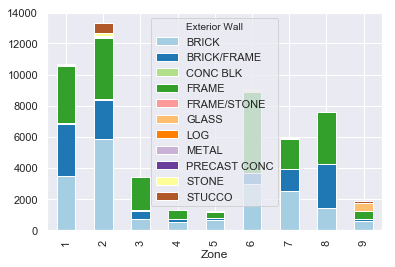

In [33]:
plt.figure(figsize=(9,9))
fig = pd.crosstab(df.Zone,df['Exterior Wall']).plot(kind='bar',stacked=True, colormap='Paired');

Text(0.5, 1.0, 'Price Distribution among Wall Types')

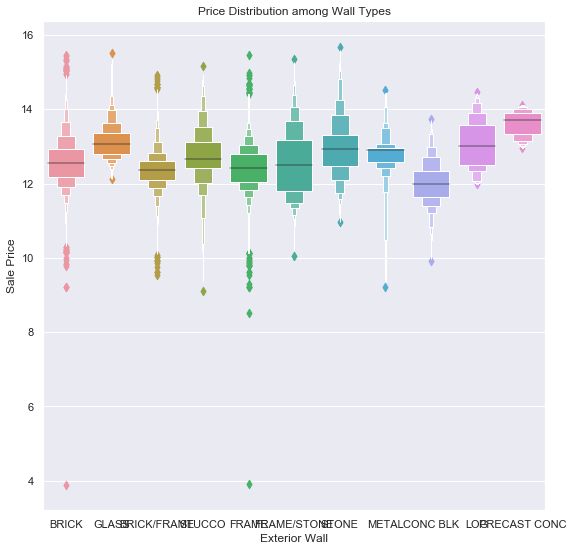

In [35]:
plt.figure(figsize=(9,9))
sns.boxenplot(x="Exterior Wall", y=np.log(df["Sale Price"]), data=df)
plt.title("Price Distribution among Wall Types")

Text(0.5, 1.0, 'Price distribution among zones')

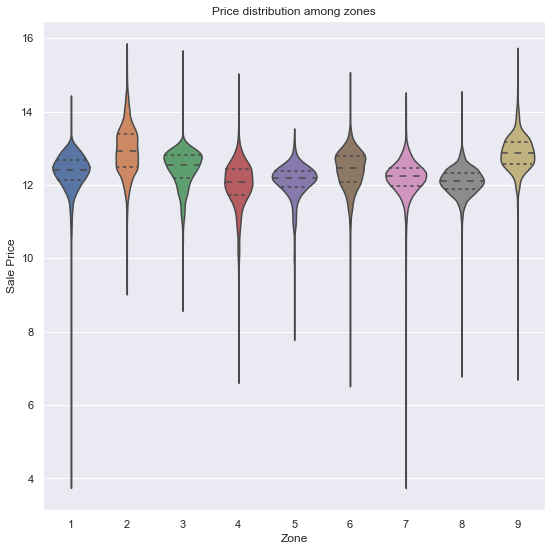

In [25]:
#Showing the price distribution among different zones, but we could use this style graph for any kind of feature.
plt.figure(figsize=(9,9))
sns.violinplot(x="Zone", y=np.log(df["Sale Price"]), data=df, inner='quartile')
plt.title("Price distribution among zones")
#Zone 9, the downtown, shows the highest sale prices

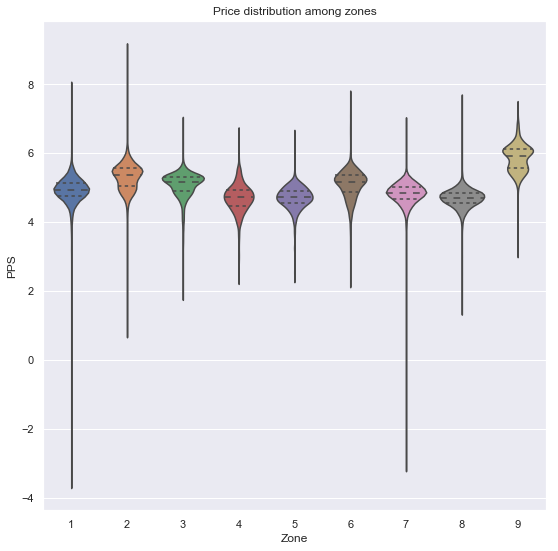

In [5]:
plt.figure(figsize=(9,9))
sns.violinplot(x="Zone", y=np.log(df["PPS"]), data=df, inner = 'quartile')
plt.title("Price distribution among zones")
plt.show()

In [7]:
df['Land Value Improved'].head(10)
#Adjacent parcels will often all have the same appraised land value. Appraised values are not generally useful for our purposes.

705    80000.0
707    80000.0
710    80000.0
711    80000.0
764    83200.0
781    65000.0
785    65000.0
791    65000.0
793    73700.0
794    73700.0
Name: Land Value Improved, dtype: float64

In [62]:
df['Tax District'].value_counts()

USD     188153
GSD      76693
GO        3905
FH        2271
CBID      2246
OH        2149
GBID      1482
BM        1282
BH         954
RT          44
LW          22
SNDG        11
SNDU         1
Name: Tax District, dtype: int64

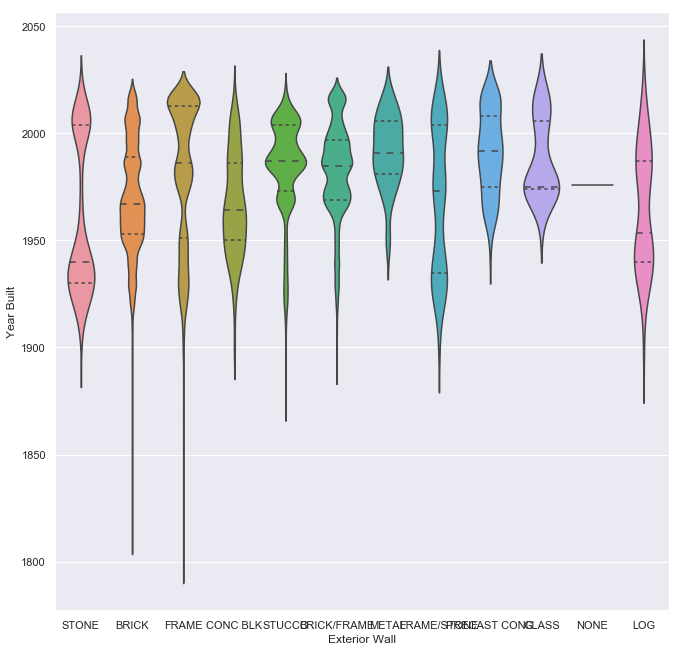

In [9]:
plt.figure(figsize=(11,11))
sns.violinplot(y=dfz2['Year Built'],x=dfz2['Exterior Wall'], inner = 'quartile')

C:\Users\alehe\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


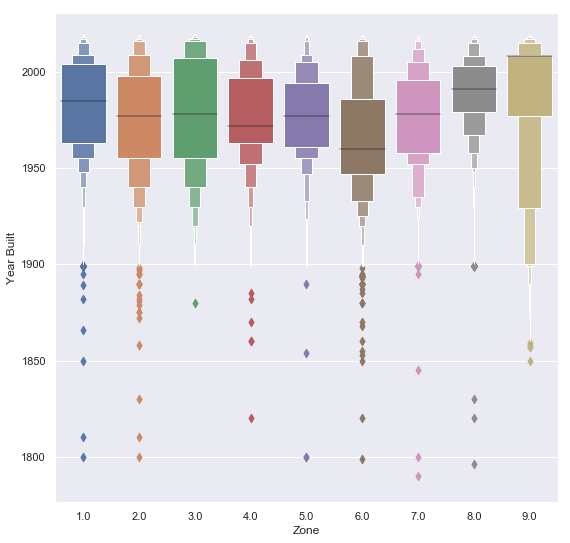

In [4]:
plt.figure(figsize=(9,9))
sns.boxenplot(x="Zone", y="Year Built", data=dfm)

#Zone 6 is showing the broadest range of values and the oldest. Perhaps it experienced gentrification at times in the past.
#Zone 9 shows the most recently-built units, but with lots of old historic stuff.
#Zone 8 shows the 2nd-most recent distribution of homes. This would reflect east nashville gentrifying.

In [49]:
df[['Square Footage Improved', 'Most Recent Sale Price Improved']].corr()
#pd.plotting.scatter_matrix(df[['Square Footage Improved', 'Most Recent Sale Price Improved']], alpha= 0.5, diagonal='kde' )

,Square Footage Improved,Most Recent Sale Price Improved
Square Footage Improved,1.00000,0.57845
Most Recent Sale Price Improved,0.57845,1.00000


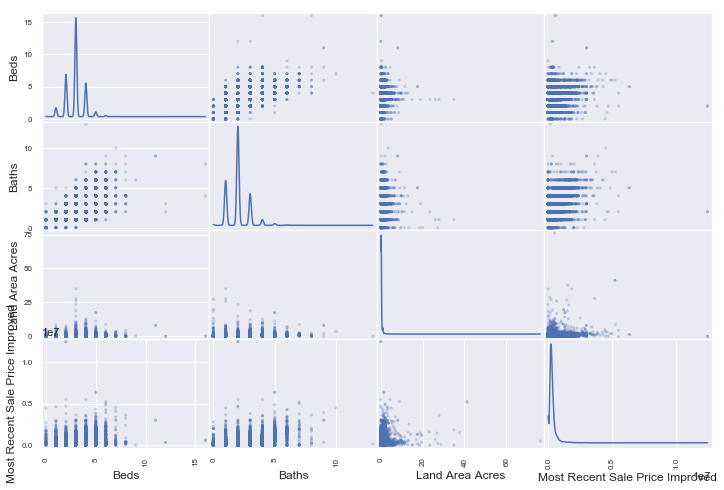

In [43]:
pd.plotting.scatter_matrix(df[['Beds','Baths', 'Land Area Acres','Most Recent Sale Price Improved']], alpha = 0.3,figsize = (12,8), diagonal = 'kde');

1.00    30617
2.00    23929
1.50     4346
1.75     2716
3.00     1629
1.25      440
2.50      147
2.25       87
2.75       59
4.00       12
Name: Story Height, dtype: int64


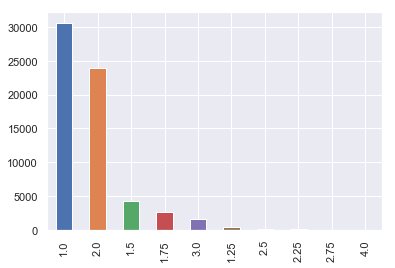

In [45]:
print(df['Story Height'].value_counts())
df['Story Height'].value_counts().plot('bar')

In [48]:
df[['Assessment Total Improved','Improvement Value Improved', 'Total Appraisal Value Improved']]

,Assessment Total Improved,Improvement Value Improved,Total Appraisal Value Improved
62806,24675.0,69700.0,98700.0
261098,207025.0,671300.0,828100.0
133257,57600.0,0.0,144000.0
167194,58100.0,187400.0,232400.0
248025,87600.0,287400.0,350400.0
204302,60675.0,194700.0,242700.0
87739,71450.0,130800.0,285800.0
131182,89450.0,132800.0,357800.0
73008,99875.0,234500.0,399500.0
60033,50425.0,163700.0,201700.0


In [46]:
len(df['Neighborhood'].unique())
#This will be getting pretty granular. We should consider trends among Zones as well.

819

2.0    16270
1.0    12720
6.0    11702
8.0     8823
7.0     7026
3.0     4796
9.0     2335
4.0     1745
5.0     1483
Name: Zone, dtype: int64


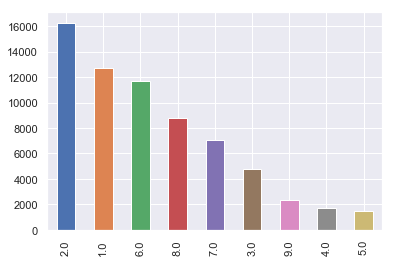

In [47]:
df.Zone.value_counts().plot('bar')
print(df.Zone.value_counts())

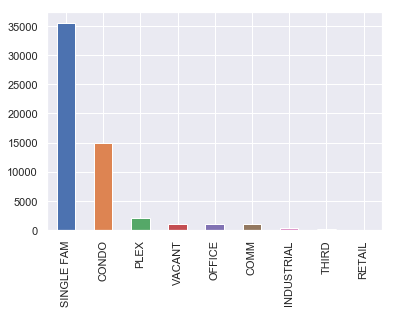

In [7]:
dfz2=df1[df1.Zone=='2']

dfz2['Building Type Custom'].value_counts().plot('bar')

#len(dfz2)

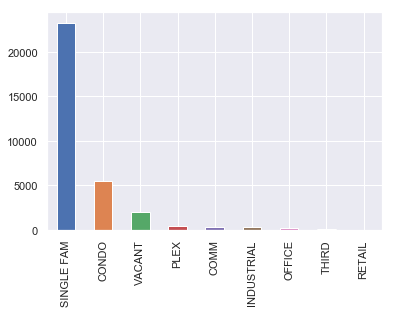

In [18]:
dfz8=dfm[dfm.Zone==8]

dfz8['Building Type Custom'].value_counts().plot('bar')

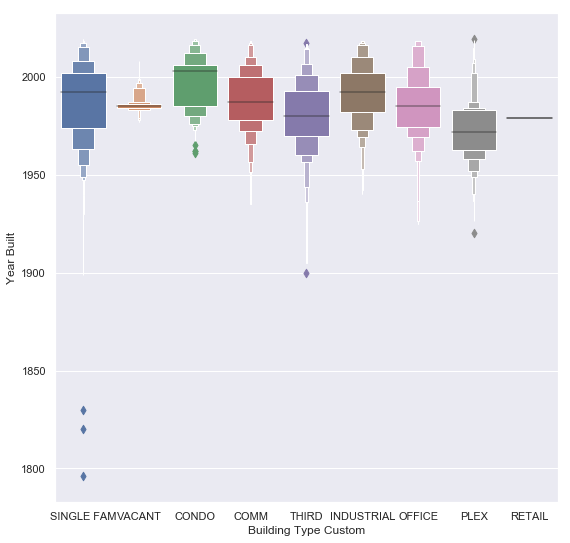

In [22]:
dfz8c= dfz8[dfz8['Building Type Custom'] == 'CONDO']
plt.figure(figsize=(9,9))
sns.boxenplot(y='Year Built', x = 'Building Type Custom', data = dfz8)

#Note the PLEX housing is the oldest.

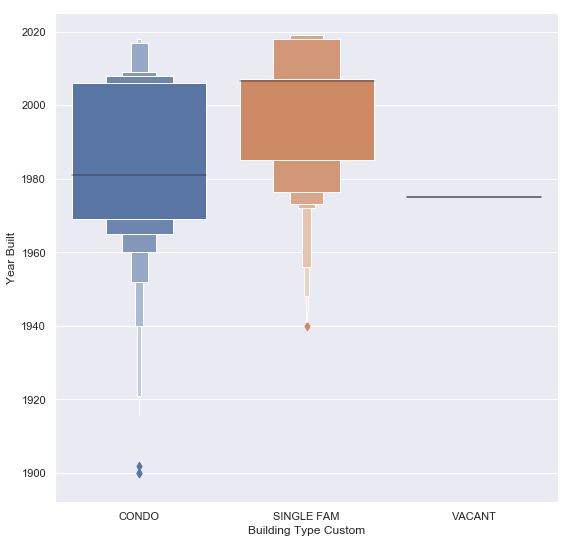

In [40]:
plt.figure(figsize=(9,9))
sns.boxenplot(y='Year Built', x = 'Building Type Custom', data = dfz2.dropna())
#PLEX is the oldest, retail's the newest, condo's the newest housing

CONDO         4410
SINGLE FAM     766
COMM           349
OFFICE         335
INDUSTRIAL     201
PLEX            86
THIRD           37
VACANT          14
RETAIL           1
Name: Building Type Custom, dtype: int64


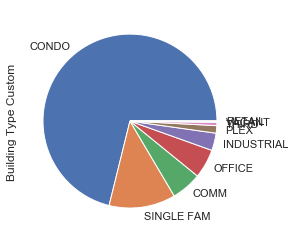

In [10]:
dfz9=df1[df1.Zone=='9']

dfz9['Building Type Custom'].value_counts().plot.pie()

print(dfz9['Building Type Custom'].value_counts())

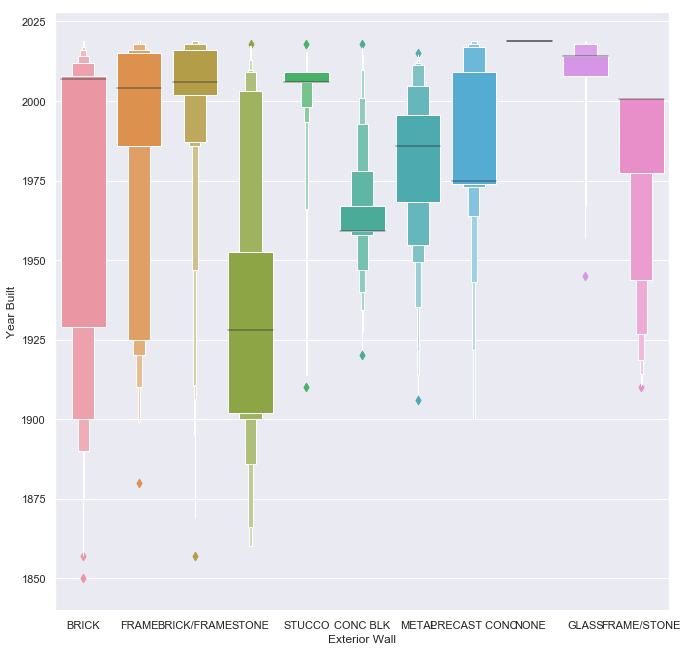

In [9]:
plt.figure(figsize=(11,11))
sns.boxenplot(x='Exterior Wall', y = 'Year Built', data = dfz9)

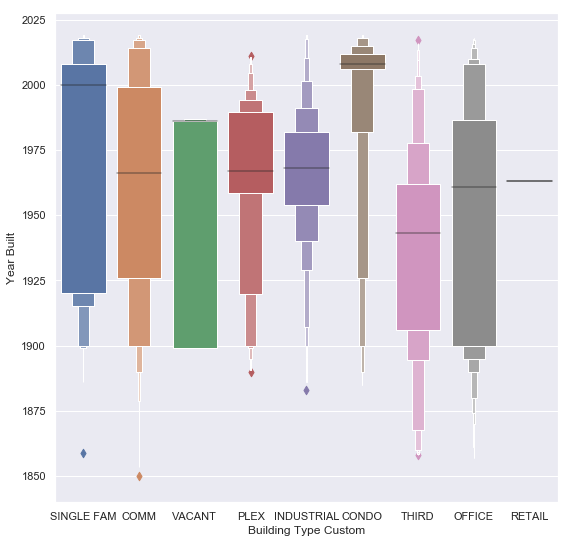

In [25]:
plt.figure(figsize=(9,9))
sns.boxenplot(y='Year Built', x = 'Building Type Custom', data = dfz9)
#Single family is the newest here.
#PLEX is the oldest

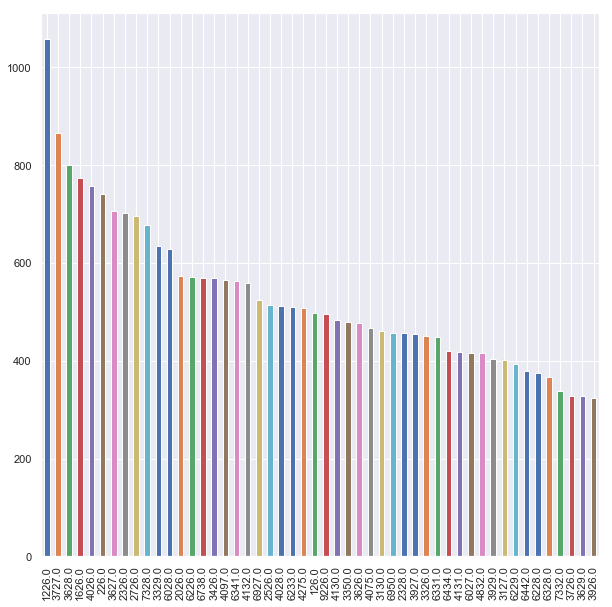

In [24]:
plt.figure(figsize=(10,10))
df.Neighborhood.value_counts()[:50].plot('bar')
plt.show()
#Nice even class distribution

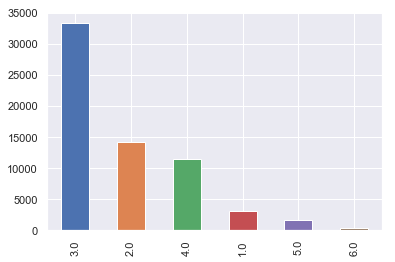

In [22]:
df.Beds.value_counts()[:6].plot('bar')

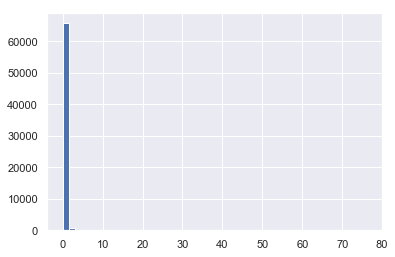

In [23]:
df['Land Area Acres'].hist(bins=50)
#We have some outliers, consider removing
#Important observation: the vsat majority of these units are multifamily (land area of 0)

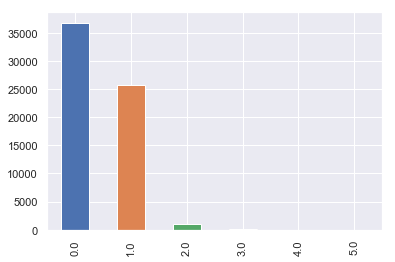

In [21]:
#Add 0.5 to Baths for each "half bath" listed?
#Or not. This is a potential indicator of PPSF
df['Half Bath'].value_counts().plot('bar')

In [20]:
df['Building Condition'].value_counts()
#I think this kind of class imbalance makes it useful for predictive purposes; if anything's different from 'Average' that's significant

Average        62780
Fair             709
Good             269
Poor             109
Very Good         49
Very Poor         34
Dilapidated       21
Excellent         11
Name: Building Condition, dtype: int64

In [19]:
df['Building Grade'].value_counts()
#We cannot use this variable. There is no guide on the Davidson CO site as to what these indicate.
#It is also safe to assume that, if you're a developer, you'll construct your new building in Grade A condition.

C      41733
B      16256
D       2528
A       2168
X       1121
E        112
TCC       14
SRB       12
SRC        8
OFB        6
OFD        3
AAC        2
ALB        2
OFC        2
TCD        2
IDC        2
TCB        2
SSD        2
TFC        1
SMD        1
SSC        1
ACB        1
IDD        1
ODB        1
SSB        1
Name: Building Grade, dtype: int64

In [1]:
print(df['Building Type Custom'].value_counts())

print(df.head())

NameError: name 'df' is not defined

In [72]:
dfn9527=df[df['Neighborhood'] == '9527.0']

dfn9527.head()

,Unnamed: 0,Assessment Classification*,Assessment Improvement,Assessment Land,Assessment Total,Assessment Year,Baths,Beds,Building Condition,Building Grade,...,Land Value Improved,Assessment Land Improved,Total Appraisal Value Improved,Square Footage Improved,Building Type Custom,Land Area Acres,PPS,NeighborhoodPPS,Assessment Ratio,NeighborhoodAR
137672,137672,RES,127825.0,89975.0,"$217,800",2019,4.0,4.0,Average,A,...,359900.0,89975.0,871200.0,4075.0,SINGLE FAM,2.44,209.815951,1022.535126,0.586892,0.541148
153699,153699,RES,0.0,8125.0,"$8,125",2019,NaN,NaN,NaN,NaN,...,32500.0,8125.0,32500.0,0.0,NaN,1.29,NaN,1022.535126,0.000000,0.541148
153719,153719,RES,230275.0,133750.0,"$364,025",2019,5.0,4.0,Good,X,...,535000.0,133750.0,1456100.0,4239.0,SINGLE FAM,1.59,294.880868,1022.535126,0.632580,0.541148
153730,153730,RES,169825.0,142475.0,"$312,300",2019,1.0,2.0,Fair,D,...,569900.0,142475.0,1249200.0,832.0,SINGLE FAM,2.41,1442.307692,1022.535126,0.543788,0.541148
153959,153959,RES,206025.0,255875.0,"$461,900",2019,1.0,1.0,Average,C,...,1023500.0,255875.0,1847600.0,485.0,SINGLE FAM,4.49,4072.164948,1022.535126,0.446038,0.541148


In [49]:
df['Ratio2'] = df['Assessment Improvement Improved'] / (df['Total Appraisal Value Improved'])

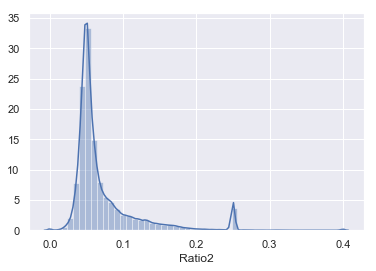

In [51]:
sns.distplot(df.Ratio2.dropna())

In [ ]:
#Want to plot meanpps neighborhoods with high assessment ratio

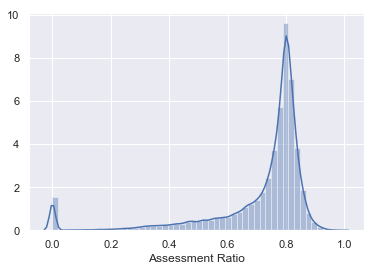

In [62]:
sns.distplot(df['Assessment Ratio'].dropna())

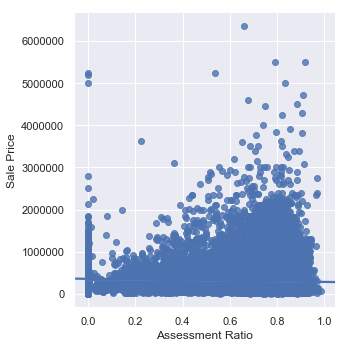

In [65]:
sns.lmplot(x='Assessment Ratio', y = 'Sale Price', data = df)
#Need to clean up data.

In [ ]:
ratioprice= pd.DataFrame(df[['Assessment Ratio', 'Sale Price', 'Year Built']])

ratioprice.corr()
#Almost no correlation whatsoever between ratio and price

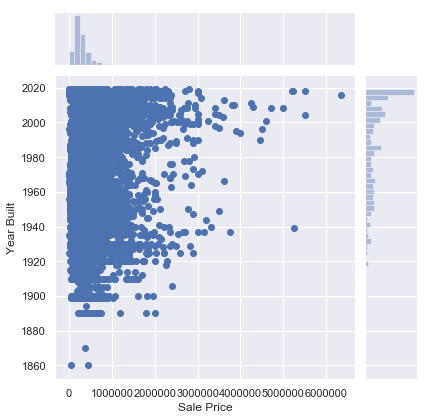

In [69]:
g = sns.jointplot("Sale Price", "Year Built", df)

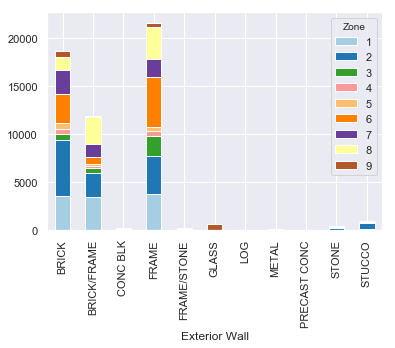

In [43]:
pd.crosstab(df['Exterior Wall'], df.Zone).plot(kind='bar',stacked=True, colormap='Paired');

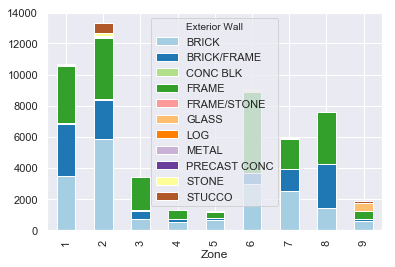

In [59]:
pd.crosstab(df.Zone,df['Exterior Wall']).plot(kind='bar',stacked=True, colormap='Paired')

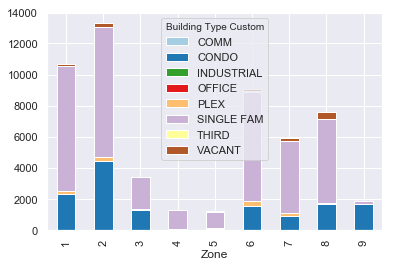

In [63]:
pd.crosstab(df.Zone,df['Building Type Custom']).plot(kind='bar',stacked=True, colormap='Paired')